# load library

In [ ]:
import dlib #이미지처리 라이브러리 , 페이스 디텍션, 랜드마크 디텍션, 페이스 얼라이브 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

# load model

In [ ]:
detector = dlib.get_frontal_face_detector()  #얼굴 영역 인식 모델 로드
sp = dlib.shape_predictor("/content/drive/MyDrive/BeautyGAN/shape_predictor_5_face_landmarks.dat")

# confirm image

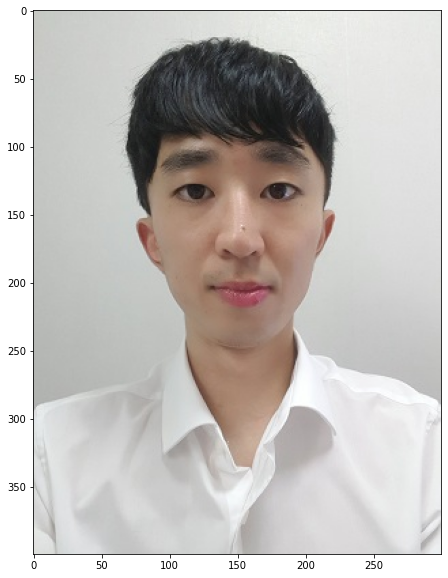

In [ ]:
img = dlib.load_rgb_image("/content/drive/MyDrive/BeautyGAN/images/300400.jpg")

plt.figure(figsize=(16,10))
plt.imshow(img)

# face detection

#### find face

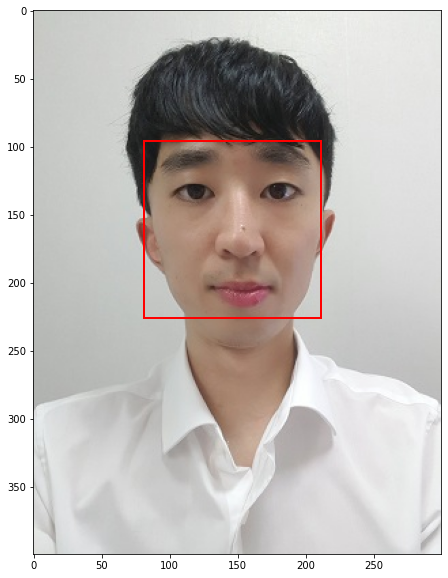

In [ ]:
img_result = img.copy()

dets = detector(img,1) #이미지에서 얼굴 영역을 찾는다.

if len(dets) == 0: #얼굴영역의 갯수가 0일 경우
  print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16,10))

for det in dets: #det이라는 직사각형 정보에 대한 for문
  x, y, w, h = det.left(), det.top(), det.width(), det.height()

  rect = patches.Rectangle((x,y),w, h, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

ax.imshow(img_result)

#### find face landmark

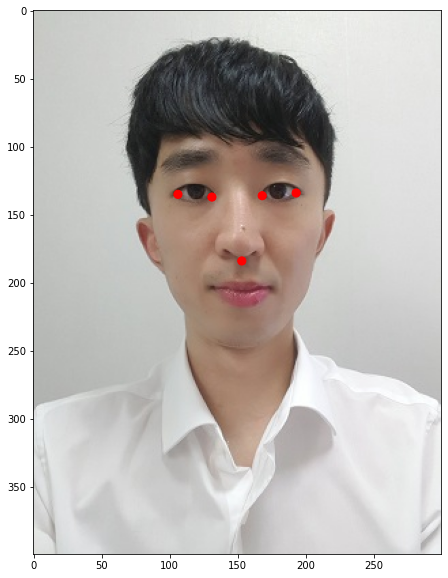

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,10))

objs =dlib.full_object_detections() #얼굴 수평맞춰줄때 사용

for detection in dets:
  s = sp(img, detection) #sp() : 얼굴의 랜드마크를 찾는다.
  objs.append(s)

  for point in s.parts(): #5개의 점에 대한 for문
    circle = patches.Circle((point.x,point.y), radius=3, edgecolor='r',facecolor='r')
    ax.add_patch(circle)

ax.imshow(img_result)

#### resize face image

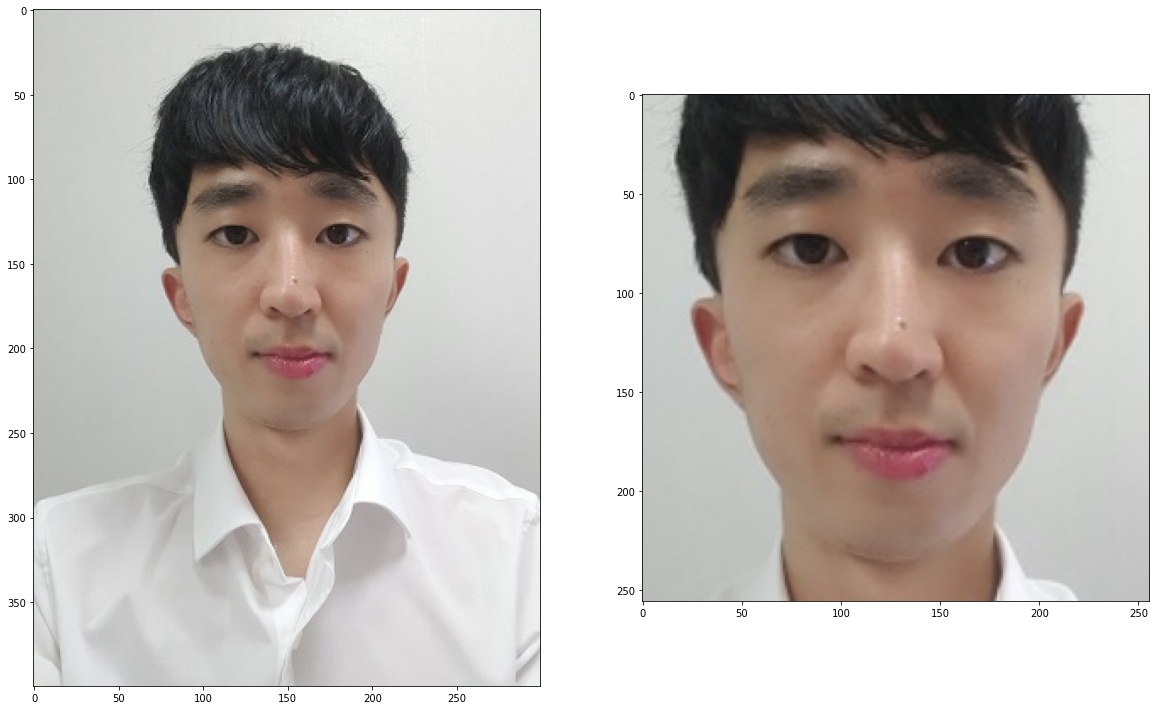

In [ ]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3) #dilb.get_face_chips() : 얼굴을 수평으로 회전하여 얼굴 부분만 자른 이미지 반환

flg,axes = plt.subplots(1, len(faces)+1, figsize=(20,16))

axes[0].imshow(img) #원본이미지

for i,face in enumerate(faces): #디텍션한 얼굴이 여러개면 여러개 찍어준다.
  axes[i+1].imshow(face)

# functionalize face detection

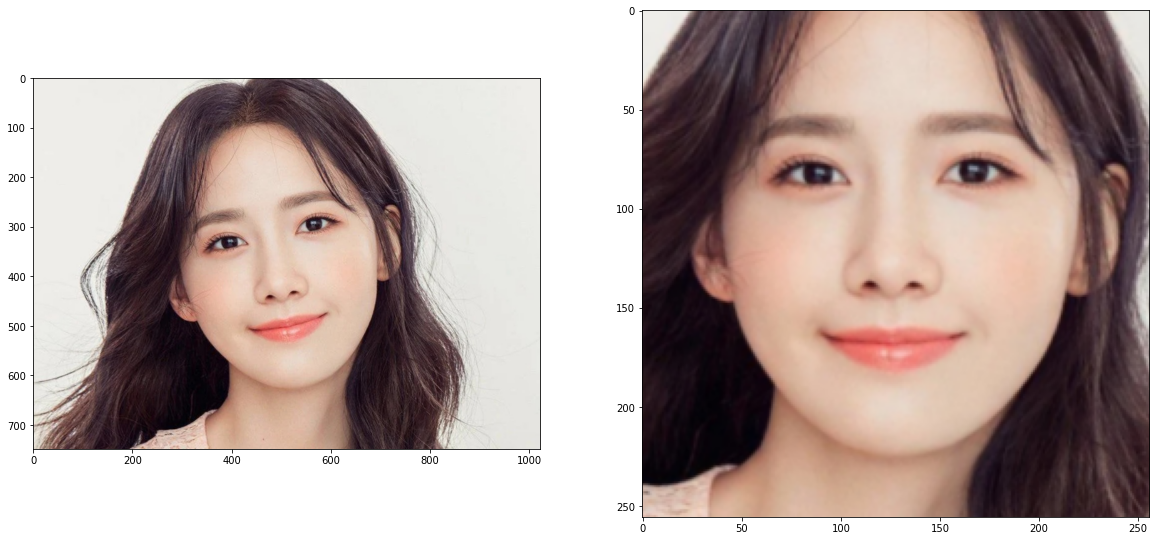

In [ ]:
def align_faces(img):  #원본이미지를 넣으면 align 완료된 얼굴이미지 반환하는 함수
  dets = detector(img,1)

  objs = dlib.full_object_detections()

  for detection in dets:
    s = sp(img, detection)
    objs.append(s)
  
  faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)

  return faces 

#test
test_img = dlib.load_rgb_image("/content/drive/MyDrive/BeautyGAN/images/spring.jpg")

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20,16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
  axes[i+1].imshow(face)

# load pretrained BeautyGAN

In [ ]:
tf.compat.v1.disable_eager_execution() #at the beginning of the program for complex migration projects from TensorFlow 1.x to 2.x.

In [ ]:
with tf.compat.v1.Session() as sess:    #위 코드를 통해 즉시실행했기 때문에 with문으로 감싸줘야한다.
  sess.run(tf.compat.v1.global_variables_initializer())

sess = tf.compat.v1.Session()
saver = tf.compat.v1.train.import_meta_graph("/content/drive/MyDrive/BeautyGAN/model.meta")
saver.restore(sess, tf.train.latest_checkpoint("/content/drive/MyDrive/BeautyGAN/"))
graph = tf.compat.v1.get_default_graph()

X = graph.get_tensor_by_name('X:0') #source
Y = graph.get_tensor_by_name('Y:0') #reference
Xs = graph.get_tensor_by_name('generator/xs:0') #output

In [ ]:
def preprocess(img):
  return img.astype(np.float32) / 127.5 -1           #0 ~ 255 -> -1 ~ 1

def postprocess(img):
  return ((img+1.)*127.5).astype(np.uint8)           #-1 ~ 1 -> 0 ~ 255

# running BeautyGAN

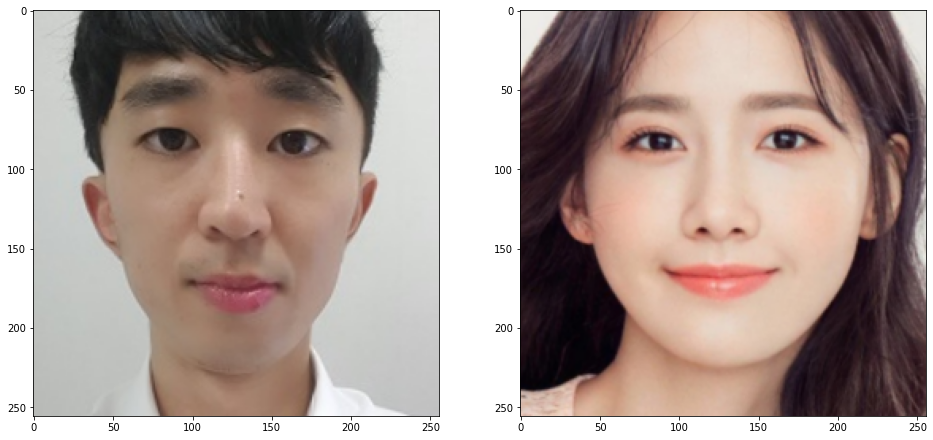

In [ ]:
img1 = dlib.load_rgb_image("/content/drive/MyDrive/BeautyGAN/images/300400.jpg")
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image("/content/drive/MyDrive/BeautyGAN/images/spring.jpg")
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16,10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

[[[[0.8238849  0.75377566 0.75528806]
   [0.88261926 0.7834477  0.79806966]
   [0.8842099  0.7962935  0.7989719 ]
   ...
   [0.9591531  0.9104618  0.9011449 ]
   [0.96801215 0.9179885  0.8936878 ]
   [0.9433836  0.8675369  0.8383555 ]]

  [[0.8629895  0.77319354 0.76536083]
   [0.8786632  0.812572   0.8133871 ]
   [0.8796476  0.8075884  0.798679  ]
   ...
   [0.9485165  0.8965224  0.8773663 ]
   [0.9672507  0.8980095  0.8664731 ]
   [0.9658817  0.8917991  0.85697114]]

  [[0.8538742  0.8057027  0.76898277]
   [0.8349089  0.8294548  0.8026533 ]
   [0.8251113  0.8019449  0.7853233 ]
   ...
   [0.9520588  0.893176   0.8776904 ]
   [0.96230507 0.9060444  0.875041  ]
   [0.96828604 0.88572174 0.86314785]]

  ...

  [[0.708573   0.61726415 0.6414024 ]
   [0.6825292  0.6409127  0.6665664 ]
   [0.70330167 0.64755833 0.6308718 ]
   ...
   [0.7770939  0.7106562  0.7107679 ]
   [0.7669697  0.7206096  0.697894  ]
   [0.7749392  0.7176769  0.6998571 ]]

  [[0.7113096  0.60927194 0.60392696]
   [0.6

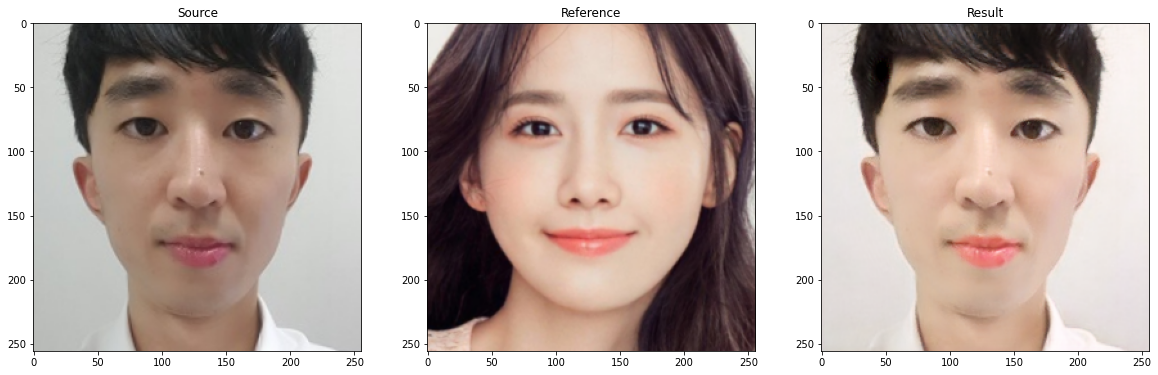

In [ ]:
src_img = img1_faces[0] #소스 이미지 
ref_img = img2_faces[0] #레퍼런스 이미지

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img,axis=0) #np.expand_dims() : 배열에 차원을 추가한다. 즉, (256,256,2) -> (1,256,256,3)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img,axis=0) #텐서플로에서 0번 axis는 배치 방향

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

#save output
plt.imsave('output.jpg',output_img)

fig,axes =plt.subplots(1,3, figsize=(20,10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)